In [1]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import gym

In [2]:
class Actor(object):
    """
        Actor Network for PPO
    """
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, ratio_clipping):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.ratio_clipping = ratio_clipping

        self.std_bound = [1e-2, 1.0] # std bound

        self.model = self.build_network()

        self.actor_optimizer = tf.keras.optimizers.Adam(self.learning_rate)

    ## actor network
    def build_network(self):
        state_input = Input((self.state_dim,))
        h1 = Dense(64, activation='relu')(state_input)
        h2 = Dense(32, activation='relu')(h1)
        h3 = Dense(16, activation='relu')(h2)
        out_mu = Dense(self.action_dim, activation='tanh')(h3)
        std_output = Dense(self.action_dim, activation='softplus')(h3)

        # Scale output to [-action_bound, action_bound]
        mu_output = Lambda(lambda x: x*self.action_bound)(out_mu)
        model = Model(state_input, [mu_output, std_output])
        model.summary()
        return model


    ## log policy pdf
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)


    ## actor policy
    def get_policy_action(self, state):
        # type of action in env is numpy array
        # np.reshape(state, [1, self.state_dim]) : shape (state_dim,) -> shape (1, state_dim)
        # why [0]?  shape (1, action_dim) -> (action_dim,)
        mu_a, std_a = self.model.predict(np.reshape(state, [1, self.state_dim]))
        mu_a = mu_a[0]
        std_a = std_a[0]
        std_a = np.clip(std_a, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu_a, std_a, size=self.action_dim)
        return mu_a, std_a, action

    ## actor prediction
    def predict(self, state):
        mu_a, _= self.model.predict(np.reshape(state, [1, self.state_dim]))
        return mu_a[0]


    ## train the actor network
    def train(self, log_old_policy_pdf, states, actions, advantages):
        with tf.GradientTape() as tape:
            # current policy pdf
            mu_a, std_a = self.model(states)
            log_policy_pdf = self.log_pdf(mu_a, std_a, actions)

            # ratio of current and old policies
            ratio = tf.exp(log_policy_pdf - log_old_policy_pdf)
            clipped_ratio = tf.clip_by_value(ratio, 1.0-self.ratio_clipping, 1.0+self.ratio_clipping)
            surrogate = -tf.minimum(ratio * advantages, clipped_ratio * advantages)
            loss = tf.reduce_mean(surrogate)
        dj_dtheta = tape.gradient(loss, self.model.trainable_variables)
        grads = zip(dj_dtheta, self.model.trainable_variables)
        self.actor_optimizer.apply_gradients(grads)

In [3]:
class Critic(object):
    """
        Critic Network for PPO: V function approximator
    """
    def __init__(self, state_dim, action_dim, learning_rate):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate

        # create and compile critic network
        self.model, self.states = self.build_network()

        self.model.compile(optimizer=Adam(self.learning_rate), loss='mse')

    ## critic network
    def build_network(self):
        state_input = Input((self.state_dim,))
        h1 = Dense(64, activation='relu')(state_input)
        h2 = Dense(32, activation='relu')(h1)
        h3 = Dense(16, activation='relu')(h2)
        v_output = Dense(1, activation='linear')(h3)
        model = Model(state_input, v_output)
        model.summary()
        return model, state_input


    ## single gradient update on a single batch data
    def train_on_batch(self, states, td_targets):
        return self.model.train_on_batch(states, td_targets)


In [4]:
class PPOagent(object):

    def __init__(self, env):

        # hyperparameters
        self.GAMMA = 0.95
        self.GAE_LAMBDA = 0.9 #0.8
        self.BATCH_SIZE = 64
        self.ACTOR_LEARNING_RATE = 0.0001
        self.CRITIC_LEARNING_RATE = 0.001
        self.RATIO_CLIPPING = 0.2
        self.EPOCHS = 10

        self.env = env
        # get state dimension
        self.state_dim = env.observation_space.shape[0]
        # get action dimension
        self.action_dim = env.action_space.shape[0]
        # get action bound
        self.action_bound = env.action_space.high[0]

        # create actor and critic networks
        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound,
                           self.ACTOR_LEARNING_RATE, self.RATIO_CLIPPING)
        self.critic = Critic(self.state_dim, self.action_dim, self.CRITIC_LEARNING_RATE)

        # save the results
        self.save_epi_reward = []


    ## computing Advantages and targets: y_k = r_k + gamma*V(s_k+1), A(s_k, a_k)= y_k - V(s_k)
    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + self.GAMMA * forward_val - v_values[k]
            gae_cumulative = self.GAMMA * self.GAE_LAMBDA * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets


    ## convert (list of np.array) to np.array
    def unpack_batch(self, batch):
        unpack = batch[0]
        for idx in range(len(batch)-1):
            unpack = np.append(unpack, batch[idx+1], axis=0)

        return unpack


    ## train the agent
    def train(self, max_episode_num):

        # initialize batch
        batch_state, batch_action, batch_reward = [], [], []
        batch_log_old_policy_pdf = []

        for ep in range(int(max_episode_num)):

            # reset episode
            time, episode_reward, done = 0, 0, False
            # reset the environment and observe the first state
            state = self.env.reset() # shape of state from gym (3,)

            while not done:

                # visualize the environment
                #self.env.render()
                # compute mu and std of old policy and pick an action (shape of gym action = (action_dim,) )
                mu_old, std_old, action = self.actor.get_policy_action(state)
                # clip continuous action to be within action_bound
                action = np.clip(action, -self.action_bound, self.action_bound)
                # compute log old policy pdf
                var_old = std_old ** 2
                log_old_policy_pdf = -0.5 * (action - mu_old) ** 2 / var_old - 0.5 * np.log(var_old * 2 * np.pi)
                log_old_policy_pdf = np.sum(log_old_policy_pdf)
                # observe reward, new_state, shape of output of gym (state_dim,)
                next_state, reward, done, _ = self.env.step(action)
                # change shape (state_dim,) -> (1, state_dim), same to mu, std, action
                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                reward = np.reshape(reward, [1, 1])
                log_old_policy_pdf = np.reshape(log_old_policy_pdf, [1, 1])

                # append to the batch
                batch_state.append(state)
                batch_action.append(action)
                batch_reward.append((reward+8)/8) # <-- normalization
                #batch_reward.append(reward)
                batch_log_old_policy_pdf.append(log_old_policy_pdf)

                # continue until batch becomes full
                if len(batch_state) < self.BATCH_SIZE:
                    # update current state
                    state = next_state
                    episode_reward += reward[0]
                    time += 1
                    continue

                # extract batched states, actions, td_targets, advantages
                states = self.unpack_batch(batch_state)
                actions = self.unpack_batch(batch_action)
                rewards = self.unpack_batch(batch_reward)
                log_old_policy_pdfs = self.unpack_batch(batch_log_old_policy_pdf)

                # clear the batch
                batch_state, batch_action, batch_reward = [], [], []
                batch_log_old_policy_pdf = []

                # compute gae and TD targets
                next_state = np.reshape(next_state, [1, self.state_dim])
                next_v_value = self.critic.model.predict(next_state)
                v_values = self.critic.model.predict(states)
                gaes, y_i = self.gae_target(rewards, v_values, next_v_value, done)

                # update the networks
                for _ in range(self.EPOCHS):

                    # train
                    self.actor.train(log_old_policy_pdfs, states, actions, gaes)
                    self.critic.train_on_batch(states, y_i)

                # update current state
                state = next_state
                episode_reward += reward[0]
                time += 1

            ## display rewards every episode
            print('Episode: ', ep+1, 'Time: ', time, 'Reward: ', episode_reward)

            self.save_epi_reward.append(episode_reward)
        print(self.save_epi_reward)


    ## save them to file if done
    def plot_result(self):
        plt.plot(self.save_epi_reward)
        plt.show()

c:\users\박정은\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           256         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
______________________________________________________________________________________________

Episode:  94 Time:  200 Reward:  [-1031.44373361]
Episode:  95 Time:  200 Reward:  [-973.93990701]
Episode:  96 Time:  200 Reward:  [-765.38895679]
Episode:  97 Time:  200 Reward:  [-1112.68376551]
Episode:  98 Time:  200 Reward:  [-835.73151099]
Episode:  99 Time:  200 Reward:  [-867.53352728]
Episode:  100 Time:  200 Reward:  [-860.39861071]
Episode:  101 Time:  200 Reward:  [-951.90419296]
Episode:  102 Time:  200 Reward:  [-766.9335036]
Episode:  103 Time:  200 Reward:  [-859.94036127]
Episode:  104 Time:  200 Reward:  [-720.51283105]
Episode:  105 Time:  200 Reward:  [-753.4722512]
Episode:  106 Time:  200 Reward:  [-883.81614158]
Episode:  107 Time:  200 Reward:  [-1036.25455149]
Episode:  108 Time:  200 Reward:  [-747.27337949]
Episode:  109 Time:  200 Reward:  [-981.00969624]
Episode:  110 Time:  200 Reward:  [-1194.71918784]
Episode:  111 Time:  200 Reward:  [-1073.95349592]
Episode:  112 Time:  200 Reward:  [-824.96798147]
Episode:  113 Time:  200 Reward:  [-679.27670363]
Epi

Episode:  258 Time:  200 Reward:  [-765.83645704]
Episode:  259 Time:  200 Reward:  [-256.51699872]
Episode:  260 Time:  200 Reward:  [-785.24548303]
Episode:  261 Time:  200 Reward:  [-0.49452549]
Episode:  262 Time:  200 Reward:  [-125.00308734]
Episode:  263 Time:  200 Reward:  [-126.88084173]
Episode:  264 Time:  200 Reward:  [-130.08189005]
Episode:  265 Time:  200 Reward:  [-1013.51487307]
Episode:  266 Time:  200 Reward:  [-2.81449785]
Episode:  267 Time:  200 Reward:  [-381.72127063]
Episode:  268 Time:  200 Reward:  [-950.67310156]
Episode:  269 Time:  200 Reward:  [-391.93005852]
Episode:  270 Time:  200 Reward:  [-421.13459673]
Episode:  271 Time:  200 Reward:  [-766.76304808]
Episode:  272 Time:  200 Reward:  [-502.27362056]
Episode:  273 Time:  200 Reward:  [-792.19839463]
Episode:  274 Time:  200 Reward:  [-388.08253911]
Episode:  275 Time:  200 Reward:  [-548.65651134]
Episode:  276 Time:  200 Reward:  [-138.23422663]
Episode:  277 Time:  200 Reward:  [-385.73013883]
Epi

Episode:  423 Time:  200 Reward:  [-130.08305985]
Episode:  424 Time:  200 Reward:  [-524.67282371]
Episode:  425 Time:  200 Reward:  [-270.65514888]
Episode:  426 Time:  200 Reward:  [-259.44924037]
Episode:  427 Time:  200 Reward:  [-264.60030606]
Episode:  428 Time:  200 Reward:  [-255.6030567]
Episode:  429 Time:  200 Reward:  [-4.06137707]
Episode:  430 Time:  200 Reward:  [-133.41110345]
Episode:  431 Time:  200 Reward:  [-249.88754449]
Episode:  432 Time:  200 Reward:  [-341.9577752]
Episode:  433 Time:  200 Reward:  [-1073.59750991]
Episode:  434 Time:  200 Reward:  [-379.77183652]
Episode:  435 Time:  200 Reward:  [-133.20362196]
Episode:  436 Time:  200 Reward:  [-401.48194707]
Episode:  437 Time:  200 Reward:  [-265.13718051]
Episode:  438 Time:  200 Reward:  [-131.54518379]
Episode:  439 Time:  200 Reward:  [-129.23453518]
Episode:  440 Time:  200 Reward:  [-1051.99144533]
Episode:  441 Time:  200 Reward:  [-265.27365181]
Episode:  442 Time:  200 Reward:  [-1272.62021044]
E

Episode:  588 Time:  200 Reward:  [-413.32590545]
Episode:  589 Time:  200 Reward:  [-126.15343953]
Episode:  590 Time:  200 Reward:  [-544.36045433]
Episode:  591 Time:  200 Reward:  [-387.08667557]
Episode:  592 Time:  200 Reward:  [-484.06433033]
Episode:  593 Time:  200 Reward:  [-129.15808198]
Episode:  594 Time:  200 Reward:  [-403.87935677]
Episode:  595 Time:  200 Reward:  [-124.72303069]
Episode:  596 Time:  200 Reward:  [-939.4076973]
Episode:  597 Time:  200 Reward:  [-132.5370698]
Episode:  598 Time:  200 Reward:  [-246.08911976]
Episode:  599 Time:  200 Reward:  [-128.91977751]
Episode:  600 Time:  200 Reward:  [-524.94310567]
Episode:  601 Time:  200 Reward:  [-132.95764102]
Episode:  602 Time:  200 Reward:  [-526.41135582]
Episode:  603 Time:  200 Reward:  [-264.75617048]
Episode:  604 Time:  200 Reward:  [-132.52518634]
Episode:  605 Time:  200 Reward:  [-264.76118795]
Episode:  606 Time:  200 Reward:  [-374.23617256]
Episode:  607 Time:  200 Reward:  [-131.38924793]
Ep

Episode:  753 Time:  200 Reward:  [-1058.45508758]
Episode:  754 Time:  200 Reward:  [-897.54217726]
Episode:  755 Time:  200 Reward:  [-665.58795601]
Episode:  756 Time:  200 Reward:  [-140.49649391]
Episode:  757 Time:  200 Reward:  [-521.31637767]
Episode:  758 Time:  200 Reward:  [-652.45180257]
Episode:  759 Time:  200 Reward:  [-666.23007276]
Episode:  760 Time:  200 Reward:  [-133.11853272]
Episode:  761 Time:  200 Reward:  [-129.64429259]
Episode:  762 Time:  200 Reward:  [-130.17853188]
Episode:  763 Time:  200 Reward:  [-379.85007057]
Episode:  764 Time:  200 Reward:  [-4.15032023]
Episode:  765 Time:  200 Reward:  [-264.82757192]
Episode:  766 Time:  200 Reward:  [-275.2845845]
Episode:  767 Time:  200 Reward:  [-501.17541744]
Episode:  768 Time:  200 Reward:  [-134.92588171]
Episode:  769 Time:  200 Reward:  [-134.68344188]
Episode:  770 Time:  200 Reward:  [-386.337631]
Episode:  771 Time:  200 Reward:  [-485.43818725]
Episode:  772 Time:  200 Reward:  [-421.27646268]
Epis

Episode:  918 Time:  200 Reward:  [-282.95453874]
Episode:  919 Time:  200 Reward:  [-250.23649865]
Episode:  920 Time:  200 Reward:  [-420.37949499]
Episode:  921 Time:  200 Reward:  [-129.8403705]
Episode:  922 Time:  200 Reward:  [-1072.74547639]
Episode:  923 Time:  200 Reward:  [-2.54013839]
Episode:  924 Time:  200 Reward:  [-261.12040703]
Episode:  925 Time:  200 Reward:  [-120.41046874]
Episode:  926 Time:  200 Reward:  [-266.41257064]
Episode:  927 Time:  200 Reward:  [-935.54483555]
Episode:  928 Time:  200 Reward:  [-1274.7765076]
Episode:  929 Time:  200 Reward:  [-1227.52702264]
Episode:  930 Time:  200 Reward:  [-1194.61692703]
Episode:  931 Time:  200 Reward:  [-1229.45070426]
Episode:  932 Time:  200 Reward:  [-244.52100836]
Episode:  933 Time:  200 Reward:  [-3.65490416]
Episode:  934 Time:  200 Reward:  [-3.23804988]
Episode:  935 Time:  200 Reward:  [-1173.77448306]
Episode:  936 Time:  200 Reward:  [-1188.0466874]
Episode:  937 Time:  200 Reward:  [-350.54181902]
Ep

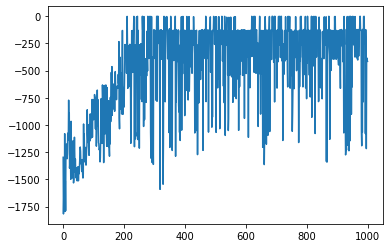

In [5]:
max_episode_num = 1000
env_name = 'Pendulum-v0'
env = gym.make(env_name)
agent = PPOagent(env)

agent.train(max_episode_num)

agent.plot_result()